In [376]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import os

### Read data

In [377]:
normalize = lambda df : (df-np.mean(df, axis=0))/np.std(df, axis=0)
transform = lambda y : 1 if y == '"Male"' else 0

X = np.genfromtxt('weight-height.csv', delimiter=',', dtype=float, skip_header=1, usecols=(1,2))
Y = np.genfromtxt('weight-height.csv', delimiter=',', dtype=str, skip_header=1, usecols=(0))

Y = np.array(list(map(transform, Y)))[:, None]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.95, random_state=42)

### Decision space

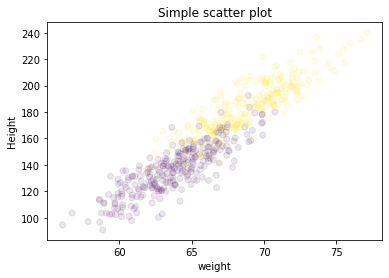

In [378]:
# Creating plot
fig, ax = plt.subplots();
ax.scatter(X_train[:,0], X_train[:,1], c=y_train, alpha=0.1);
ax.set_ylabel("Height")
ax.set_xlabel("weight")
ax.set_title("Simple scatter plot");

### Theory

We are intrested in the linear classifier of the form: </br>
$f(x) = sign(<W,x> + b)$

Note that if we multiply w and b by the same constant a this does not change the classifier. We want to remove this degree of freedom. For now assume data can be perfectly seperated by a hyperplane. We say that the pair (w,b) is in canonical form with respect to the points x if they are scaled such that: </br>
$\min_{\forall x \in X} |<W,x> +b| = 1$
We also say that the hyperplane is in canonical representation

Let $H := \{X \in \mathbb{R}^d | <W, x> + b = 0\}$ be a hyperplane. Assume that the hyperplane correctly seperates the training data. Then the margin of the hyperplane H with respect to the training points $(x_i, y_i)_{\forall i}$ is defined as the minimal distance of training point to the hyperplane: </br>

$\rho(H,x_1,...,x_n) := \min_{\forall x \in X} d(x_i, H) := \min_{\forall x \in X} \min_{\forall h \in H} ||x_i - h||$


It could be proved that for a hyperplane in canonical representation, the margin $\rho$ can be computed by $\rho = ||w||^{-1}$


Consquently, we want to maximize the margin while ensuring two constraints. Firstly that all points are on the correct side of the hyperplane, and secondly, that all points are outside the margin: 


${\displaystyle minimize_{w \in \mathbb{R}, b \in \mathbb{R}} \frac{1}{2}||w||^{2}}$ </br>
Subject to: ${\displaystyle Y_i(<w, x_i>+b) \geq  1}$

### Dual problem

It turns out that tall the important properties of SVM can only be seen from the dual optimization problem. 

So let ut derive the dual problem.

*** 

<strong> The Primal Problem </strong></br>
${\displaystyle minimize_{w \in \mathbb{R}, b \in \mathbb{R}} \frac{1}{2}||w||^{2}}$ </br>
Subject to: ${\displaystyle Y_i(<w, x_i>+b) \geq  1}$

*** 

<strong> Lagrange </strong></br>
We introduce one Lagrange multiplier $\alpha_i \geq 0$ for each constrain and write down the lagrangian: </br>
${\displaystyle L(\omega, b, \alpha) = \frac{1}{2}||\omega||^{2} - \sum_n \alpha_i(Y_i(<\omega, x_i> +b)-1)}$

Note the negative sign of the constrains is a direct result of alligning the constrains with respect to the formulation of the lagrangian   

*** 


<strong>Dual problem:</strong></br>
$\max_{\alpha} f(\alpha)=\min_{\omega, b} L(\omega, b, \alpha)$ </br>
Subject to $\alpha_i \geq 0 \quad \forall_{i}$

But this is pretty abstract, we would need to first compute the dual function, but this seems non-trivial. We now show how to compute $f(\alpha)$ explicitly. Lets try to simplify the Lagrangian first. We know that at the solution of the primal, the saddle point condition has to hold and consequently: </br>
$\frac{d}{db} L(\omega, b, \alpha) = - \sum_n \alpha_iY_i = 0$ ($*$)</br>
$\frac{d}{d\alpha} L(\omega, b, \alpha) = \omega - \sum_n \alpha_iY_iX_i = 0$ ($**$)</br>
$\implies \quad  L(\omega^{*}, b^{*}, \alpha^{*}) = \sum_{n} \alpha_{i} - \frac{1}{2} \sum_{n} \alpha_{i} \alpha_{j} Y_{i} Y_{j}<X_{i}, X_{j}> = f(\alpha) $

Now we can finally write down the dual optimization problem, we have to keep enforcing ($*$) and ($**$) otherwise the transformation of the lagrangian to its simpler form is no longer valid. By now ($**$) is meaningless as $\omega$ disappered already so we drop it. So finally we end up with the dual problem of the linear hard margin SVM: </br></br>

$\max_{\alpha} \sum_{n} \alpha_{i} - \frac{1}{2} \sum_{n} \alpha_{i} \alpha_{j} Y_{i} Y_{j}<X_{i}, X_{j}>$ </br>
Subject to: 
</br>$\quad \alpha_i \geq 0 \quad \forall_{i}$
</br>$\quad \sum_n \alpha_i Y_i = 0$


*** 
<strong>Dual SVM in practice:</strong>
- Given the input data, compute all the scalar product $<X_i,X_j>$
- Solve the dual optimization problem (It is convex), this gives you $\alpha_i$
- Recover $\omega$ and $b$ from the dual varaibles $\alpha$

<strong>Recovering the Primal Optimal Variables $b$ and $\omega$ from the dual solution</strong></br>
To compute $\omega$ directly use $(**)$: $\omega = \sum_{n} X_{i}Y_{i}\alpha_{i}$
To compute $b$ we need to exploit the Karush–Kuhn–Tucker (KKT) condition of the soft margin SVM. To compute b, we thus select a point $X_i$ that lies on the margin which is an index i with $0 \leq \alpha_i \leq C/n$ and then solve $Y_{i}(<\omega, X_{i}> + b) = 1$ for $b$. To increase the numerical stability, we might all such points and then take the average.

<strong>Evaluate labels</strong></br>
Now we can evaluate the label of the test points X:</br>
$Y_{i} = sign(<W, X> + b)$
$Y_{i} = sign(\sum_{\forall i \in I} \alpha_{i} X_{i} X + \frac{1}{J}\sum_{\forall j \in J}(Y_{j} - \sum_{\forall i \in I} \alpha_{i} X_{i} X_{j} ) )$</br>
where $ J = \{j | 0 \leq \alpha \leq C/n\}$

***
<strong>Solve the primal or dual?</strong></br>
Because we know that for quadratic problems we have a strong duality, we could either solver the primal or the dual problem. The primal has d+1 variables and n constraints. If d is small compared to n then it makes sense to solve the primal problem. The dual problem has n variables and n+1 constraints. If d is large compared to n then  it is better to solve the dual problem. In most SVM libraries, this is the default.


<strong>Solve the dual using SMO?</strong></br>
basically we will use a technique called coordinate descent. The basic idea is start at a feasable $\alpha$ (e.g. all 0). Then change $\alpha$ one cordinate at a time while ensuring all constraints remain satisfied. Hence, we would keep all but $\alpha_{r}$ fixed and choose an $\alpha_{r}$ to maximize the dual function. However, one issue with this approach is: 
</br>$\quad \sum_n \alpha_i Y_i = 0$ implies that: $ \alpha_{r}Y_{r} + \sum_{i \neq r} \alpha_{i}Y_{i} = 0$ which enforces $\alpha_{r} = -\frac{\sum_{i \neq r} \alpha_{i}Y_{i}}{Y_{r}}$ so we cannot change $\alpha_{r}$
To mitigate this issue we keep all but $\alpha_{r}, \alpha_{s}$ fixed, and choose values to maximize the dual problem. Thereby the previous issue could be solved: $ \alpha_{r}Y_{r} + \alpha_{s}Y_{s} + \sum_{i \notin \{r,s\}} \alpha_{i}Y_{i} = 0 \implies [\psi = -\sum_{i \notin \{r,s\}} \alpha_{i}Y_{i}] \implies \alpha_{s} = \frac{\psi - \alpha_{r}Y_{r}}{Y_{s}}$. Consequently we have handled the first constrain, however, we also need to satisfy:
</br>$0 \leq \alpha_r \leq C \quad (*) $
</br>$0 \leq \alpha_s \leq C \quad (**)$ 
</br> From $(**)$ it could be shown $0 \leq \frac{\psi - \alpha_{r}Y_{r}}{Y_{s}} \leq C \implies \frac{\psi}{Y_{r}} \geq \alpha_{r} \geq \frac{ \psi - C Y_{s}}{Y_{r}}$ However, remember $Y_i \in \{-1,1\}$ and therefore we will get two different results dependent on $Y_{s}, Y_{r}$:
</br> $ \frac{\psi}{Y_{r}} \geq \alpha_{r} \geq \frac{\psi - C Y_{s}}{Y_{r}} \quad (Y_r = Y_s)  $
</br> $ \frac{\psi}{Y_{r}} \leq \alpha_{r} \leq \frac{ \psi - C Y_{s}}{Y_{r}} \quad (Y_r \neq Y_s)$ 
</br> In order to also fullfill $(*)$ we need to rewrite the previous constraints to the folowing: 
</br> $ min(\frac{\psi}{Y_{r}}, C) \geq \alpha_{r} \geq max(\frac{\psi - C Y_{s}}{Y_{r}}, 0) \quad (Y_r = Y_s)  $
</br> $ max(\frac{\psi}{Y_{r}},0) \leq \alpha_{r} \leq min(\frac{ \psi - C Y_{s}}{Y_{r}}, C) \quad (Y_r \neq Y_s)$ 

In [490]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

def kernel(f, centered=False, **kwargs):
    if centered: 
        return lambda a, b: centerKernel(f(a,b, **kwargs))
    return lambda a, b: f(a,b, **kwargs)

def centerKernel(k):
    return k - np.mean(k, axis=1)[:,None] - np.mean(k, axis=0)[None,:] + np.mean(k)

def kLinear(X, Y):
    return np.dot(X, Y.T)


def kGaussian(X, Y, sigma=1):   
    A = np.atleast_2d(X); B = np.atleast_2d(Y)
    return np.array([np.exp(-np.linalg.norm(a - B, axis=1) / (2.0 * sigma ** 2)) for a in A])

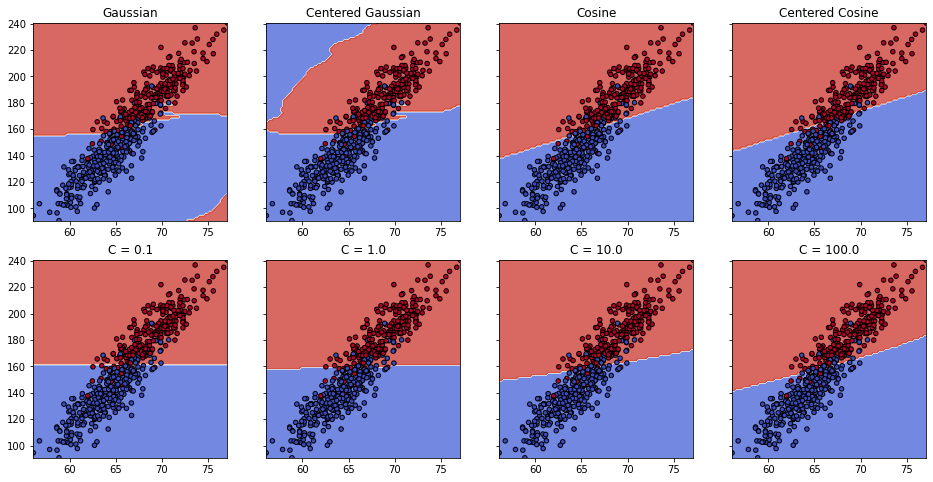

In [526]:
models = [
    {'label': 'Gaussian', 'params': {'kernel': kernel(kGaussian)}},
    {'label': 'Centered Gaussian', 'params': {'kernel': kernel(kGaussian, centered=True)}},
    {'label': 'Cosine', 'params': {'kernel': kernel(kLinear)}},
    {'label': 'Centered Cosine', 'params': {'kernel': kernel(kLinear, centered=True)}},
    {'label': 'C = 0.1', 'params': {'C': 0.1}},
    {'label': 'C = 1.0', 'params': {'C': 1.0}},
    {'label': 'C = 10.0', 'params': {'C': 10}},
    {'label': 'C = 100.0', 'params': {'C': 100.0}}
]

fig, axis = plt.subplots(2, 4, figsize=(16,8), sharey=True)
for (ax,model) in zip(axis.ravel(), models):
    svclassifier = SVC(**model['params'])
    svclassifier.fit(X_train, y_train.ravel())
    
    ax.set_title(model['label'])
    # Set-up grid for plotting.

    x_min, y_min = np.min(X_train, axis=0)
    x_max, y_max = np.max(X_train, axis=0)

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = svclassifier.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8);
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [525]:
svclassifier = SVC(C=1, kernel=kernel(kGaussian, centered=True))
svclassifier.fit(X_train, y_train.ravel())
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[4339  399]
 [ 418 4344]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      4738
           1       0.92      0.91      0.91      4762

    accuracy                           0.91      9500
   macro avg       0.91      0.91      0.91      9500
weighted avg       0.91      0.91      0.91      9500

